# Chapter 12: Modeling categorical relationships

In [1]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, chi2
import pingouin as pg
import matplotlib

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
%load_ext rpy2.ipython

# import NHANES package
base = importr('NHANES')

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['Weight']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(123456)


## Table 12.1


In [2]:
candyDf = pd.DataFrame({'Candy Type': ["chocolate", "licorice", "gumball"],
                            'Count': [30, 33, 37]})
candyDf['nullExpectation'] = [candyDf.Count.sum() / 3] * 3
candyDf['squaredDifference'] = (candyDf.Count - candyDf.nullExpectation) ** 2

candyDf

,Candy Type,Count,nullExpectation,squaredDifference
0,chocolate,30,33.333333,11.111111
1,licorice,33,33.333333,0.111111
2,gumball,37,33.333333,13.444444


## Figure 12.1

In [3]:
chisqVal = np.sum(candyDf.squaredDifference / candyDf.nullExpectation)
chisqVal

0.7399999999999999

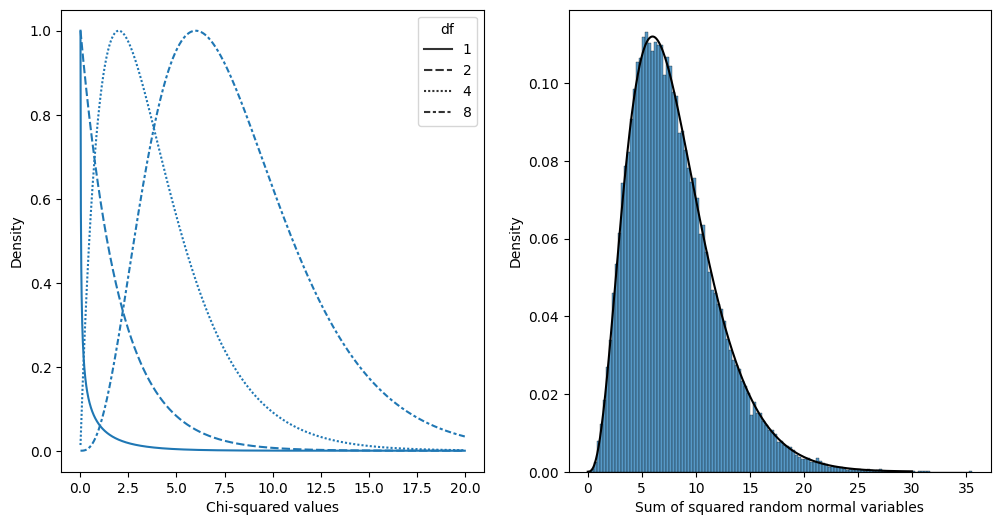

In [4]:
x = np.arange(0.01, 20, .01)
dfvals = [1, 2, 4, 8]

x_df = [(i, j) for i in x for j in dfvals]

chisqDf = pd.DataFrame(x_df, columns = ['x', 'df'])
chisqDf['chisq'] = chi2.pdf(chisqDf.x, chisqDf.df)
for df in dfvals:
    chisqDf.loc[chisqDf.df == df, 'chisq'] = chisqDf[chisqDf.df == df]['chisq'] / chisqDf[chisqDf.df == df]['chisq'].max()
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.lineplot(data=chisqDf, x='x', y='chisq', style='df', ax=ax[0])
ax[0].set_xlabel("Chi-squared values")
ax[0].set_ylabel('Density')


# simulate 50,000 sums of 8 standard normal random variables and compare
# to theoretical chi-squared distribution

# create a matrix with 50k columns of 8 rows of squared normal random variables
dSum = (rng.normal(size=(50000, 8)) ** 2).sum(axis=1)

sns.histplot(dSum, ax=ax[1], stat='density')
ax[1].set_ylabel("Density")
ax[1].set_xlabel("Sum of squared random normal variables")

csDf = pd.DataFrame({'x': np.arange(0.01, 30, 0.01)})
csDf['chisq'] = chi2.pdf(csDf.x, 8)
_ =sns.lineplot(data=csDf, x='x', y='chisq', ax=ax[1], color='black')



## Table 12.2

In [5]:
stopData = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/CT_data_cleaned.csv')
table = pd.crosstab(stopData['driver_race'], stopData['search_conducted'], margins=True)
print(table)
n = stopData.shape[0]
print('')
print('Normalized:')
table_normalized = pd.crosstab(stopData['driver_race'], stopData['search_conducted'], margins=True, normalize='all')
print(table_normalized)

search_conducted   False  True     All
driver_race                           
Black              36244  1219   37463
White             239241  3108  242349
All               275485  4327  279812

Normalized:
search_conducted     False      True       All
driver_race                                   
Black             0.129530  0.004356  0.133886
White             0.855006  0.011107  0.866114
All               0.984536  0.015464  1.000000


## Chi-squared test result

In [6]:
expected = np.outer(table_normalized.values[:2, 2], table_normalized.values[2, :2]) * n
actual = pd.crosstab(stopData['driver_race'], stopData['search_conducted'], margins=False)
diff = expected - actual
stdSqDiff = diff **2 / expected
chisq = stdSqDiff.sum().sum()
pval = chi2.pdf(chisq, 1)
pval

1.9001204194035138e-182

In [7]:
_, _, stats = pg.chi2_independence(stopData, 'driver_race', 'search_conducted')
stats[stats.test=='pearson']

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,827.005515,1.0,7.255988e-182,0.054365,1.0


## Table 12.3

In [8]:
summaryDfResids = diff/ np.sqrt(expected)
summaryDfResids

search_conducted,False,True
driver_race,,
Black,3.330746,-26.576456
White,-1.309550,10.449072


## Bayes factor

In [9]:
%%R -i actual

# compute Bayes factor
# using independent multinomial sampling plan in which row totals (driver race)
# are fixed
library(BayesFactor)
bf <-
  contingencyTableBF(as.matrix(actual),
  sampleType = "indepMulti",
  fixedMargin = "cols"
)
bf

R[write to console]: Error in library(BayesFactor) : there is no package called ‘BayesFactor’




Error in library(BayesFactor) : there is no package called ‘BayesFactor’


RInterpreterError: Failed to parse and evaluate line '\n# compute Bayes factor\n# using independent multinomial sampling plan in which row totals (driver race)\n# are fixed\nlibrary(BayesFactor)\nbf <-\n  contingencyTableBF(as.matrix(actual),\n  sampleType = "indepMulti",\n  fixedMargin = "cols"\n)\nbf\n'.
R error message: 'Error in library(BayesFactor) : there is no package called ‘BayesFactor’'

## Table 12.4

In [1]:
NHANES_sleep = NHANES.query('Age > 17').dropna(subset=['SleepTrouble', 'Depressed'])
depressedSleepTrouble = pd.crosstab( NHANES_sleep.Depressed, NHANES_sleep.SleepTrouble)
depressedSleepTrouble

NameError: name 'NHANES' is not defined

## Chi-squared result

In [ ]:
_, _, stats = pg.chi2_independence(NHANES_sleep, 'SleepTrouble', 'Depressed')
stats[stats.test=='pearson']

## Bayes factor

In [ ]:
%%R -i depressedSleepTrouble

# compute bayes factor, using a joint multinomial sampling plan
bf <-
  contingencyTableBF(
    as.matrix(depressedSleepTrouble),
    sampleType = "jointMulti"
  )
bf